<a href="https://colab.research.google.com/github/mgczacki/iap/blob/main/proyecto/DL_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final

## Introducción al aprendizaje profundo

### Autor: Mario Horacio Garrido Czacki

In [1]:
# Colab
! pip install torchinfo

In [76]:
# funciones aleatorias
import random
# sistema de archivos
import os
# flush!
import sys
# procesamiento xml
import xml.etree.ElementTree as ET
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

#regex
import re
#titulos largos
from textwrap import wrap
#pandas
import pandas as pd
#f1
from sklearn.metrics import f1_score

### 1.2 Utilerias

In [3]:
# directorio de datos
DATA_DIR = ''

# tamaño del lote
BATCH_SIZE = 32# tamaño de la imagen
IMG_SIZE = 512

# filas y columnas de la cuadrícula 
ROWS, COLS = 2, 2

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def display_grid(rows, cols, xs, x_text, y_true, dic, y_pred=None, figsize=(14, 7)):
    """Despliega ejemplos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            img = xs[i]
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            tstring = "Texto: "+ "\n".join(wrap(x_text[i], 50)) + "\nReal: " + str(binary_list_to_class
                                                                                (y_true[i], dic))
            if y_pred is not None:
                tstring = tstring + "\nPred: " + str(binary_list_to_class(y_pred[i], dic))
            ax[r, c].set_title(tstring)
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(rows, cols, x, x_text, y_true, dic, y_pred=None, figsize=(14, 7)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    y_true = y_true.numpy().astype(np.uint8)
    if y_pred is not None:
        y_pred = y_pred.numpy().astype(np.uint8)
    display_grid(rows, cols, x, x_text, y_true, dic, y_pred, figsize=figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


# reproducibilidad
set_seed()

### Uso del GPU

In [4]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 2 Datos

### 2.1 Conjunto de datos principal: PropagandaDS

- Memes con fines propagandísticos
- Texto transcrito
- Se identifican 22 falacias argumentativas posibles para cada una.

In [5]:
import json

Genero diccionarios necesarios.

In [6]:
"""
# ¿Cuáles son las clasificaciones en el dataset?
classifications = set()

for filepath in ['training_set_task3/training_set_task3.txt', 
                 'test_set_task3/test_set_task3.txt', 
                 'dev_set_task3_labeled/dev_set_task3_labeled.txt']:
    
    with open(filepath) as f:
        data = json.load(f)
        for d in data:
            for l in d['labels']:
                classifications.add(l)

"""
classifications = {'Appeal to (Strong) Emotions',
 'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Transfer',
 'Whataboutism'}

¿Cuáles son las clasificaciones del dataset?

In [7]:
classifications

{'Appeal to (Strong) Emotions',
 'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Transfer',
 'Whataboutism'}

Genero diccionarios útiles

In [8]:
t_class_idx = list(enumerate(classifications, 0))

In [9]:
t_class_idx

[(0, 'Causal Oversimplification'),
 (1, 'Bandwagon'),
 (2, 'Appeal to authority'),
 (3, "Misrepresentation of Someone's Position (Straw Man)"),
 (4, 'Name calling/Labeling'),
 (5, 'Whataboutism'),
 (6, 'Loaded Language'),
 (7, 'Obfuscation, Intentional vagueness, Confusion'),
 (8, 'Appeal to fear/prejudice'),
 (9, 'Doubt'),
 (10, 'Smears'),
 (11, 'Black-and-white Fallacy/Dictatorship'),
 (12, 'Glittering generalities (Virtue)'),
 (13, 'Repetition'),
 (14, 'Transfer'),
 (15, 'Thought-terminating cliché'),
 (16, 'Appeal to (Strong) Emotions'),
 (17, 'Slogans'),
 (18, 'Presenting Irrelevant Data (Red Herring)'),
 (19, 'Exaggeration/Minimisation'),
 (20, 'Reductio ad hitlerum'),
 (21, 'Flag-waving')]

In [10]:
t_idx_class = [t[::-1] for t in t_class_idx]

In [11]:
t_idx_class

[('Causal Oversimplification', 0),
 ('Bandwagon', 1),
 ('Appeal to authority', 2),
 ("Misrepresentation of Someone's Position (Straw Man)", 3),
 ('Name calling/Labeling', 4),
 ('Whataboutism', 5),
 ('Loaded Language', 6),
 ('Obfuscation, Intentional vagueness, Confusion', 7),
 ('Appeal to fear/prejudice', 8),
 ('Doubt', 9),
 ('Smears', 10),
 ('Black-and-white Fallacy/Dictatorship', 11),
 ('Glittering generalities (Virtue)', 12),
 ('Repetition', 13),
 ('Transfer', 14),
 ('Thought-terminating cliché', 15),
 ('Appeal to (Strong) Emotions', 16),
 ('Slogans', 17),
 ('Presenting Irrelevant Data (Red Herring)', 18),
 ('Exaggeration/Minimisation', 19),
 ('Reductio ad hitlerum', 20),
 ('Flag-waving', 21)]

Diccionarios para traducir a índices.

In [12]:
idx_class = dict(t_class_idx)

In [13]:
class_idx = dict(t_idx_class)

In [14]:
idx_class[0]

'Causal Oversimplification'

In [15]:
class_idx['Name calling/Labeling']

4

In [16]:
# Paso de una lista de enteros a un encoding binario con tope i
def binary_list(l, i):
    return np.array([1 if (i in l) else 0 for i in range(i)])

In [17]:
def binary_list_to_class(l, d):
    l = np.asarray(l == 1).nonzero()[0]
    return [d[i] for i in l]

Preprocesamiento de texto. Esto implica la tokenización y la limpieza del mismo.

In [18]:
from nltk.tokenize import TweetTokenizer

In [19]:
tknzr = TweetTokenizer()

In [20]:
#http://people.csail.mit.edu/mcollins/6864/slides/bikel.pdf

def preprocess(s):
    s = s.lower()
    s = re.sub(r'[.]',' ', s)
    s = re.sub(r'\n(\s*\n)*',' . ', s)
    s = re.sub(r'@',' @ ', s)
    s = re.sub(r'#',' # ', s)
    s = re.sub(r'\s+',' ', s)
    s = re.sub(r'[0-9]','0', s)
    s = re.sub(r'[!]\s[!]+','!', s)
    s = re.sub(r'[?]\s[?]+','?', s)
    s = re.sub(r'[?]+','?', s)
    s = re.sub(r'[!]+','!', s)
    s = re.sub(r'(?<=[a-z])[,.]*','', s)
    s = re.sub(r'([.]\s*)+',".", s)
    s = re.sub(r'[\'`]s'," X", s)
    s = re.sub(r'\s*[.]\s*$','', s)
    return s

In [21]:
def tokenize(s):
    s.replace("\n"," ")
    return ["'s'" if x == "X" else x for x in tknzr.tokenize(s)]

Dataset a utilizar.

In [22]:
# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class PropagandaDS:

    def __init__(self, idx_class, class_idx, img_transform = None, text_transform = None, root = "./", section = 'trn', download=False):
        self.root = join(root, 'PropagandaDS')
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.idx_class = idx_class
        self.class_idx = class_idx
        self.section = section
        
        os.makedirs(self.root, exist_ok = True)
        
        assert section in ["trn", "tst", "dev"], "Section should be trn, tst or dev."
        
        if download:
            self.download(section)

        if not self._check_integrity(section):
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')
        
        # guardamos filenames
        self.filenames = os.listdir(self.dir)
        #quitar los .txt
        self.filenames = [x for x in self.filenames if (x.endswith(".txt") == False)]
        
        # abrimos el json adjunto y guardamos labels/texto asociados a las imagenes
        with open(join(self.dir, self.dsname+".txt")) as f:
            data = json.load(f)
            #labels transformadas
            self.img_labels = dict(map(lambda d : (d['image'], binary_list(list(map(class_idx.get, d['labels'])), 22) ), data))
            #texto en la imagen
            self.img_text = dict(map(lambda d : (d['image'], d['text']), data))
            self.text = dict(map(lambda d : (d['image'], text_transform(d['text'])), data))
            self.vocab = set()
            for i in self.text.values():
                self.vocab = self.vocab.union(set(i))
        
        self.balance = (len(list(self.img_labels.values())) - np.sum(list(self.img_labels.values()), axis=0))/np.sum(list(self.img_labels.values()), axis=0)
        self.balance[self.balance == np.inf] = 1
    def __getitem__(self, index):
        filename = self.filenames[index]
        
        img = Image.open(join(
            self.dir,                  
            filename)
        )
        # si la imagen es escala de grises
        # transformamos a RGB
        if img.mode == 'L':
            rgbimg = Image.new('RGB', img.size)
            rgbimg.paste(img)
            img = rgbimg

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, torch.IntTensor(self.img_labels[filename]), self.img_text[filename], torch.IntTensor(np.array(list(map(self.global_voc.get, self.text[filename]))))

    def __len__(self):
        return len(self.filenames)
    
    def _check_integrity(self, section):
        
        path = self.root
        
        if section == "trn":
            path = join(path, "training_set_task3")
            self.dsname = "training_set_task3"
        elif section == "tst":
            path = join(path, "test_set_task3")
            self.dsname = "test_set_task3"
        else:
            path = join(path, "dev_set_task3_labeled")
            self.dsname = "dev_set_task3_labeled"
        
        self.dir = path
        return os.path.exists(path)

    def download(self, section):
        if self._check_integrity(section):
            print('Files already downloaded and verified')
            return
        
        url = ""
        filename = ""
        md5 = ""
        download_root = ""
        
        if section == "trn":
            url = "https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/raw/main/data/training_set_task3.zip"
            download_root = self.root
            md5 = "9d4eecc126f1f7e2cfe3146df00db68b"
            filename = "training_set_task3.zip"
        elif section == "tst":
            url = "https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/raw/main/data/test_set_task3.zip"
            download_root = self.root
            md5 = "c6b147c8b1f1f165c9d47899912420ae"
            filename = "test_set_task3.zip"
        else:
            url = "https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/raw/main/data/dev_set_task3.zip"
            download_root = self.root
            md5 = "94e08340f06cd96452f10eaba8e05c01"
            filename = "dev_set_task3.zip"        
        tvu.download_and_extract_archive(
            url=url,
            download_root=download_root,
            filename=filename,
            md5=md5
        )

### 2.2 Transformación

In [23]:
class Rescale:

    def __init__(self, size, img_tsfm):
        self.size = size
        self.img_tsfm = img_tsfm

    # hace el objeto llamable, 
    # se comporta como una una función
    def __call__(self, img):
        # obtenemos las dimensiones originales
        img = self.img_tsfm(img)
    
        return img

### 2.3 Instancia del conjunto y partición

In [24]:
from torch.nn.utils.rnn import pad_sequence
#https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/ ?
def pad_collate_p(batch):
    (ww, xx, yy, zz) = zip(*batch)
    z_lens = torch.IntTensor((np.array([len(z) for z in zz])))

    zz_pad = torch.IntTensor(pad_sequence(zz, batch_first=True, padding_value=0))

    return torch.stack(ww), torch.stack(xx), yy, zz_pad, z_lens

In [25]:
# transofrmación de la imagen
img_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


# transformación conjunta del ejemplo
tsfm = Rescale(IMG_SIZE, img_tsfm)


trn_ds = PropagandaDS(idx_class, class_idx, img_transform = tsfm, text_transform = lambda x: tokenize(preprocess(x)), section = 'trn', download=True)
tst_ds = PropagandaDS(idx_class,  class_idx, img_transform = tsfm, text_transform = lambda x: tokenize(preprocess(x)), section = 'tst', download=True)
dev_ds = PropagandaDS(idx_class, class_idx, img_transform = tsfm, text_transform = lambda x: tokenize(preprocess(x)), section = 'dev', download=True)

len(trn_ds), len(tst_ds), len(dev_ds)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<ipython-input-22-1c9dd96472e0>:41: RuntimeWarning: divide by zero encountered in true_divide
  self.balance = (len(list(self.img_labels.values())) - np.sum(list(self.img_labels.values()), axis=0))/np.sum(list(self.img_labels.values()), axis=0)


(687, 200, 63)

¿Cómo está el balanceo de clases en el dataset?

<BarContainer object of 22 artists>

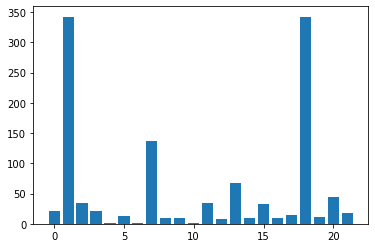

In [26]:
plt.bar(range(22),trn_ds.balance)

<BarContainer object of 22 artists>

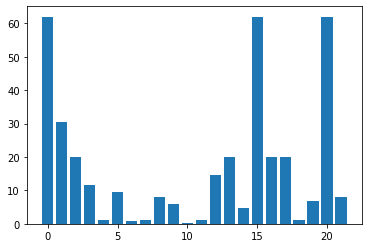

In [27]:
plt.bar(range(22),dev_ds.balance)

In [28]:
interest_vocab = trn_ds.vocab.union(dev_ds.vocab).union(tst_ds.vocab)

In [29]:
len(interest_vocab)

3863

GloVe Embeddings.

In [30]:
# Descargar embeddings en caso de que no estén, puede tardar un rato

from torchtext.vocab import GloVe
embedding_glove = GloVe(name='twitter.27B', dim=50)

In [31]:
embedding_glove["."]

tensor([ 0.6866, -1.0772,  0.0111, -0.2407, -0.3422,  0.6446,  0.5496,  0.3041,
        -0.5468,  1.4695,  0.4365, -0.3422, -2.7189,  0.4602,  0.0169,  0.1395,
         0.0209,  0.0510, -0.4811, -1.0764, -0.1681, -0.0143, -0.5505,  0.6782,
         0.2436, -1.3179, -0.0363, -0.2280,  1.0337, -0.5322, -0.5293,  0.3554,
        -0.4491,  0.7951,  0.5695,  0.0716, -0.2745, -0.0569, -0.4296, -0.6441,
        -1.3495,  0.2326,  0.2538, -0.1023,  0.6582,  0.1602,  0.2096, -0.0675,
        -0.5195, -0.3492])

### Dataset de noticias con técnicas propagandisticas adaptado al problema

In [32]:
# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class NewsDS:

    def __init__(self, idx_class, class_idx, transform = None, root = "./", download=False, download_only = False):
        self.root = join(root, 'NewsDS')
        self.transform = transform
        self.idx_class = idx_class
        self.class_idx = class_idx
        #self.section = section
        
        os.makedirs(self.root, exist_ok = True)
        
        #assert section in ["trn", "dev"], "Section should be trn or dev."
        
        if download:
            self.download()

        #Solo descargar los datos
        if download_only:
            return None
            
        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')
        
        # guardamos rutas de archivos
        self.filepath = join(self.root, "datasets")
        
        #Las clases están desbalanceadas. Es mejor unificar los datasets y hacer un split aleatorio.
        
        filepath_articles = [join(filepath, "train-articles"), join(filepath, "dev-articles")]
        filepath_labels = [join(filepath, "train-task-flc-tc.labels"), join(filepath, "dev-task-flc-tc.labels")]
        
        # Cargamos articulos y extraemos spans
        dataset = []
        
        self.text = []
        self.preprocessed_text = []
        self.labels = []

        self.vocab = set()
        
        for i in range(2):
        
            try:
                labels = pd.read_csv(filepath_labels[i], header = None, sep = "\t")
                labels.columns = ["Article", "Techniques", "Span Start", "Span End"]


                articles = set(labels['Article'])

                for a in articles:
                    with open(join(filepath_articles[i], f"article{a}.txt"), "r") as f:
                        txt = f.read()
                    df_a = labels[labels['Article']  == a]

                    #to_delete = []
                    for index, row in df_a.iterrows():
                        span_start = row['Span Start']
                        span_end = row['Span End']
                        new_start, new_end = largespan(txt, span_start, span_end)

                        #Texto encontrado
                        span_txt = txt[new_start:new_end]

                        span_tags = set()

                        for index_b, row_b in df_a.iterrows():
                            if new_start <= row_b['Span Start'] <= new_end or new_start <= row_b['Span End'] <= new_end:
                                for tag in row_b['Techniques'].split(","):
                                    span_tags.add(class_idx_2[tag])

                        span_tags = binary_list(span_tags, 19)

                        dataset.append((span_txt, span_tags))

            except:
                raise Exception("Faliure while loading "+filepath_labels[i])


        #Generar estructuras internas y preprocesamiento
        for txt, l in dataset:
            ptxt = txt

            if(self.transform != None):
                ptxt = self.transform(txt)
                self.vocab = self.vocab.union(set(ptxt))

            if(len(ptxt) == 0):
                continue

            self.text.append(txt)
            self.preprocessed_text.append(ptxt)
            self.labels.append(l)
        
        self.balance = (len(self.labels) - np.sum(self.labels, axis=0))/np.sum(self.labels, axis=0)
        
    def __getitem__(self, index):

        return self.text[index], torch.IntTensor(np.array(list(map(self.global_voc.get, self.preprocessed_text[index])))), self.labels[index]

    def __len__(self):
        return len(self.text)
    
    def _check_integrity(self):
        
        return os.path.exists(join(self.root, "datasets"))

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        
        tvu.download_and_extract_archive(
            url="https://propaganda.qcri.org/ptc/data/ptc-corpus.tgz",
            download_root=self.root,
            filename="ptc-corpus.tgz",
            md5="3544966683297bd6aca6526cb5036655"
        )

In [33]:
NewsDS(None, 
       None, 
       transform = None, 
       download=True,
       download_only = True)

Files already downloaded and verified


Ahora que existen los datos, genero los diccionarios necesarios.

In [34]:
#"https://propaganda.qcri.org/ptc/data/ptc-corpus.tgz"
filepath = "../ptc-corpus/datasets/"

In [35]:
labels_trn = pd.read_csv(filepath + "train-task-flc-tc.labels", header = None, sep = "\t")
labels_trn.columns = ["Article", "Techniques", "Span Start", "Span End"]
labels_trn.head(10)

,Article,Techniques,Span Start,Span End
0,111111111,Appeal_to_Authority,265,323
1,111111111,Appeal_to_Authority,1795,1935
2,111111111,Doubt,149,157
3,111111111,Repetition,1069,1091
4,111111111,Appeal_to_fear-prejudice,1334,1462
5,111111111,Appeal_to_fear-prejudice,1577,1616
6,111111111,Appeal_to_fear-prejudice,1856,1910
7,111111111,Appeal_to_fear-prejudice,2023,2086
8,111111112,Slogans,191,219
9,111111112,Black-and-White_Fallacy,476,556


Función de transformación.

Los artículos y spans se convierten a oraciones que contienen las técnicas argumentativas.

In [36]:
def largespan(txt, span_start, span_end):
    splitpoints = np.array([m.end(0) for m in re.finditer(r'(\n|[.])',txt)])
    before_span = splitpoints[splitpoints < span_start]
    after_span = splitpoints[splitpoints > span_end]
    new_start = 0 if len(before_span) == 0 else np.max(before_span)
    new_end = len(txt)-1 if len(after_span) == 0 else np.min(after_span)
    return new_start, new_end

In [37]:
labels_trn = pd.read_csv(filepath + "train-task-flc-tc.labels", header = None, sep = "\t")
labels_trn.columns = ["Article", "Techniques", "Span Start", "Span End"]
labels_trn = labels_trn.groupby(['Article'])['Techniques'].apply(','.join).apply(
    lambda x : set(x.split(","))).reset_index()
labels_trn

,Article,Techniques
0,111111111,"{Appeal_to_Authority, Appeal_to_fear-prejudice..."
1,111111112,"{Slogans, Black-and-White_Fallacy, Name_Callin..."
2,111111113,"{Slogans, Name_Calling, Labeling, Loaded_Langu..."
3,111111114,{Appeal_to_fear-prejudice}
4,111111115,"{Appeal_to_Authority, Loaded_Language}"
...,...,...
352,999001296,"{Name_Calling, Loaded_Language, Labeling, Stra..."
353,999001297,"{Repetition, Loaded_Language}"
354,999001619,"{Name_Calling, Loaded_Language, Labeling, Caus..."
355,999001621,"{Name_Calling, Labeling, Loaded_Language, Caus..."


In [38]:
labels_dev = pd.read_csv(filepath + "dev-task-flc-tc.labels", header = None, sep = "\t")
labels_dev.columns = ["Article", "Techniques", "Span Start", "Span End"]
labels_dev = labels_dev.groupby(['Article'])['Techniques'].apply(','.join).apply(
    lambda x : set(x.split(","))).reset_index()
labels_dev

,Article,Techniques
0,730093263,"{Loaded_Language, Straw_Men, Flag-Waving, Red_..."
1,730246508,"{Loaded_Language, Flag-Waving}"
2,730269378,"{Straw_Men, Red_Herring, Whataboutism, Causal_..."
3,738028498,"{Appeal_to_Authority, Appeal_to_fear-prejudice..."
4,738361208,"{Slogans, Name_Calling, Loaded_Language, Label..."
...,...,...
69,999001280,"{Name_Calling, Loaded_Language, Labeling, Caus..."
70,999001290,"{Name_Calling, Labeling, Loaded_Language, Stra..."
71,999001299,"{Name_Calling, Loaded_Language, Labeling, Doub..."
72,999001323,"{Name_Calling, Labeling, Loaded_Language, Flag..."


In [39]:
list(labels_dev.itertuples(index=False, name=None))[0]

(730093263,
 {'Flag-Waving',
  'Loaded_Language',
  'Red_Herring',
  'Straw_Men',
  'Whataboutism'})

In [40]:
classifications_2 = set()
for s in labels_trn["Techniques"]:
    classifications_2 = classifications_2.union(s)

classifications_2 = {'Appeal_to_Authority',
 'Appeal_to_fear-prejudice',
 'Bandwagon',
 'Black-and-White_Fallacy',
 'Causal_Oversimplification',
 'Doubt',
 'Exaggeration',
 'Flag-Waving',
 'Labeling',
 'Loaded_Language',
 'Minimisation',
 'Name_Calling',
 'Red_Herring',
 'Reductio_ad_hitlerum',
 'Repetition',
 'Slogans',
 'Straw_Men',
 'Thought-terminating_Cliches',
 'Whataboutism'}

classifications_2

{'Appeal_to_Authority',
 'Appeal_to_fear-prejudice',
 'Bandwagon',
 'Black-and-White_Fallacy',
 'Causal_Oversimplification',
 'Doubt',
 'Exaggeration',
 'Flag-Waving',
 'Labeling',
 'Loaded_Language',
 'Minimisation',
 'Name_Calling',
 'Red_Herring',
 'Reductio_ad_hitlerum',
 'Repetition',
 'Slogans',
 'Straw_Men',
 'Thought-terminating_Cliches',
 'Whataboutism'}

In [41]:
t_class_idx_2 = list(enumerate(classifications_2, 0))
t_idx_class_2 = [t[::-1] for t in t_class_idx_2]
idx_class_2 = dict(t_class_idx_2)
class_idx_2 = dict(t_idx_class_2)

Inicializo el dataset de las noticias.

In [42]:
ds_2 = NewsDS(idx_class_2, 
              class_idx_2, 
              transform = lambda x : tokenize(preprocess(x)), 
              download=True)
len(ds_2)

Files already downloaded and verified


7191

Text(0.5, 1.0, 'Balance de clases')

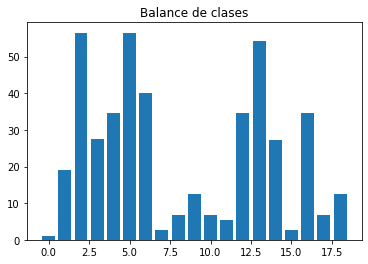

In [43]:
plt.bar(range(19),ds_2.balance)
plt.title("Balance de clases")

Partición aleatoria.

In [44]:
trn_ds_2, dev_ds_2 = random_split(ds_2, [6300, 891], generator=torch.Generator().manual_seed(42))

len(trn_ds_2), len(dev_ds_2)

(6300, 891)

Genero vocabularios para embeddings.

In [45]:
from collections import defaultdict

In [46]:
interest_vocab = ds_2.vocab.union(interest_vocab)
#Diccionarios del vocabulario e indices
voc_tup = list(enumerate(interest_vocab, 2))
idx_voc = dict([(0,"<pad>"), (1,"<unk>")]+voc_tup)
voc_idx = defaultdict(lambda : 1, [t[::-1] for t in [(0,"<pad>")]+voc_tup])
#Asigno vocabularios globales a datasets
ds_2.global_voc = voc_idx

In [47]:
print(idx_voc[0])
print(idx_voc[1])
print(voc_idx['<pad>'])
print(voc_idx['aapad'])

<pad>
<unk>
0
1


Funciones para el padding de las RNN.

In [48]:
from torch.nn.utils.rnn import pad_sequence
#https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/ ?
def pad_collate(batch):
    (xx, yy, zz) = zip(*batch)
    y_lens = torch.IntTensor((np.array([len(y) for y in yy])))

    yy_pad = torch.IntTensor(pad_sequence(yy, batch_first=True, padding_value=0))

    return xx, yy_pad, torch.Tensor(zz), y_lens

In [49]:
def _init_fn(worker_id):
    np.random.seed(12 + worker_id)

In [50]:
trn_dl_2 = DataLoader(
    # conjunto
    trn_ds_2,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    #padding
    collate_fn=pad_collate
)
dev_dl_2 = DataLoader(
    # conjunto
    dev_ds_2,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    #padding
    collate_fn=pad_collate
)

Genero la matriz de pesos pre-entrenados GloVe que tendrá la capa de embeddings en la red recurrente.

In [51]:
#https://medium.com/mlearning-ai/load-pre-trained-glove-embeddings-in-torch-nn-embedding-layer-in-under-2-minutes-f5af8f57416a

matrix_len = len(interest_vocab)
weights_matrix = np.zeros((matrix_len + 2, 50))
words_found = 0

for i, word in enumerate(interest_vocab, 2):
    emb = embedding_glove[word]
    if np.count_nonzero(emb) != 0: 
        weights_matrix[i] = emb
        words_found += 1
    else:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

weights_matrix[1] = np.mean(weights_matrix[2:], axis=0)

## Modelo 1: GRU para NewsDS

En este primer modelo generaré una GRU que aprenda a discernir las técnicas argumentativas en NewsDS. Posteriormente se hará transferencia de conocimiento a la red PropagandaDS.

In [52]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class GRUTagger(nn.Module):

    def __init__(self, stacked_layers, dropout_p, weights_matrix, embedding_dim, hidden_dim, output_size = 19):
        super(GRUTagger, self).__init__()
        
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la GRU
        self.stacked_layers = stacked_layers # Cuantas capas en la GRU
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).float(), freeze = True)
        
        
        self.gru = nn.GRU(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            batch_first = True,
                            bidirectional = True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim * 2, output_size)


    def forward(self, inp, inp_len, device):
        
        emb = self.embedding(inp)

        emb_padded = pack_padded_sequence(emb, inp_len, batch_first=True, enforce_sorted=False)
        
        output, _ = self.gru(emb_padded)
        
        seq_unpacked, lens_unpacked  = pad_packed_sequence(output, batch_first=True)
        
        output = seq_unpacked[torch.arange(emb.size()[0]), lens_unpacked-1]
        
        output = self.fc1(output)
        
        return output

In [53]:
model = GRUTagger(2, 0.4, weights_matrix, 50, 50)

In [54]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         (723,350)
├─GRU: 1-2                               76,200
├─Linear: 1-3                            1,919
Total params: 801,469
Trainable params: 78,119
Non-trainable params: 723,350

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650" height="450"> -->

In [55]:
!nvidia-smi

Sat Jun 12 01:04:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 46%   45C    P0    N/A /  75W |    417MiB /  4039MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0  On |                  N/A |
| 37%   

In [56]:
# movemos el modelo 
model.embedding.eval()
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [57]:
criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.tensor(ds_2.balance).to(device))
optimizer = optim.Adam(model.parameters())#, lr=0.0005)#, weight_decay = 2e-4)#, weight_decay = 2e-4)#, lr = 1e-2, momentum = 0.2)

In [58]:
loss_per_epoch = [0]
training_loss = [0]
stop_after_best = 5
start_training_embeddings_at = 100
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
last_epoch_save = 0

###############################################
Current epoch: 26
Last model save was in epoch 21
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.15942973734309832
[Best iter] dev loss is: 0.21546524284141405
###############################################
[Last iter] training loss was: 0.13690951095922343
[Last iter] dev. loss was: 0.22412683176142828
###############################################


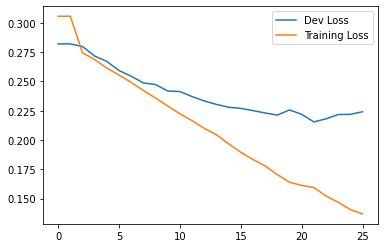

Epoch 26 Train:   0%|          | 0/197 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 26 Test: 100%|██████████| 28/28 [00:00<00:00, 151.44it/s]

Finished Training


In [59]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.legend(["Dev Loss", "Training Loss"])
    plt.show()
    
    model.train()
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        for param in model.embedding.parameters():
            param.requires_grad = True
    else:
        print("Embeddings are not being trained yet.")
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl_2, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl_2)):

        _, x, y_true, y_lens = data
        
        x = x.to(device)
        
        
        y_true = y_true.to(device).float()
        
        y_pred = model(x,y_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl_2, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl_2)):
            
            _, x, y_true, y_lens = data
            
            x = x.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(x,y_lens, device)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

    l = np.mean(val_loss_epoch)        
    
    epochs_without_change += 1
    if best_l is None or best_l >= l:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')

## 5. Probando

In [60]:
model = torch.load('best-model.pt')

model = model.to('cpu')

### 5.1 Evaluando en dev

In [61]:
x, y, z, y_l = next(iter(dev_dl_2))

In [62]:
a = model.forward(y, y_l, 'cpu')

In [63]:
r = torch.round(torch.sigmoid(a))
r

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [64]:
z

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0

Es algo dificil de visualizar el desempeño. Lo que es notable es que en las clases sobrerepresentadas, el modelo tiene buen desempeño. En las clases con menos muestras, es claro que este desmpeño sigue sin ser el mejor.

### Cargadores de datos para PropagandaDS

Ahora que se tiene un modelo para posiblemente hacer transferencia de conocimiento, se abordará el conjunto de datos a tratar.

In [65]:
trn_ds.global_voc = voc_idx
dev_ds.global_voc = voc_idx
tst_ds.global_voc = voc_idx

In [66]:
BATCH_SIZE = 16

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    #padding
    collate_fn=pad_collate_p
)
dev_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    #padding
    collate_fn=pad_collate_p
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    #padding
    collate_fn=pad_collate_p
)

¿Cómo se ven los datos?

In [67]:
ww, xx, yy, zz_pad, z_lens = next(iter(trn_dl))

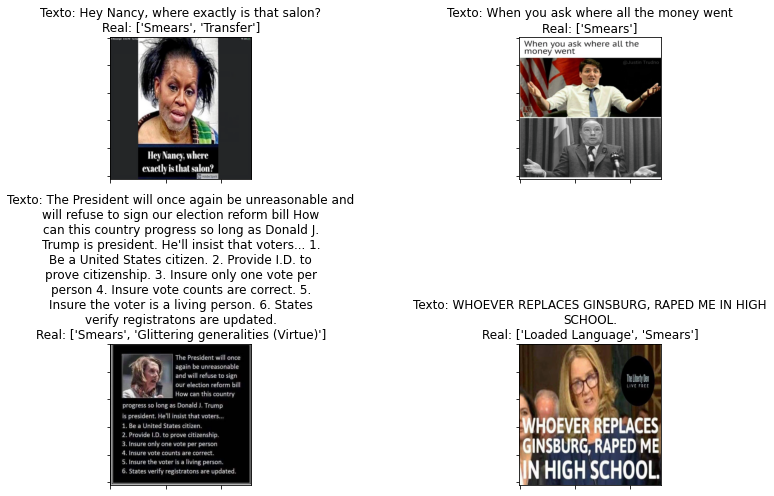

In [68]:
display_batch(ROWS, COLS, ww, yy, xx, idx_class, y_pred=None)

## Modelo convolucional

En esta primera iteración, se realizará una predicción sobre las imágenes por sí mismas. No creo que la red convolucional tenga la capacidad de capturar toda la información que el texto contiene (ya que es una arquitectura muy reducida) pero si es posible tener un grado de predicción correcta sobre los datos, es indicativo de que las imágenes pueden usarse para complementar al texto.

In [77]:
class ConvNet(nn.Module):
    
    def __init__(self, pretrained = True, pretrained_freeze = True):
        super(ConvNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()
        #self.cnn.classifier = nn.Identity()

        in_features_cnn = 1024
        # armamos la capa de regresión
     
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features_cnn),
            nn.Linear(in_features_cnn, 500),
            nn.LeakyReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 22)
        )
        if pretrained_freeze:
            #congelado de características
            for param in self.cnn.parameters():
                param.requires_grad = False
            #solo entreno las últimas capas convolucionales
            for param in self.cnn.conv5.parameters():
                param.requires_grad = True
    def forward(self, img):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(img)
        # [N, 1024] => [N, 22]
        x = self.reg(x)
        return x

In [78]:
model_cnn = ConvNet()

In [79]:
summary(model_cnn)

Layer (type:depth-idx)                   Param #
├─ShuffleNetV2: 1-1                      --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (648)
|    |    └─BatchNorm2d: 3-2             (48)
|    |    └─ReLU: 3-3                    --
|    └─MaxPool2d: 2-2                    --
|    └─Sequential: 2-3                   --
|    |    └─InvertedResidual: 3-4        (2,400)
|    |    └─InvertedResidual: 3-5        (1,512)
|    |    └─InvertedResidual: 3-6        (1,512)
|    |    └─InvertedResidual: 3-7        (1,512)
|    └─Sequential: 2-4                   --
|    |    └─InvertedResidual: 3-8        (8,256)
|    |    └─InvertedResidual: 3-9        (5,328)
|    |    └─InvertedResidual: 3-10       (5,328)
|    |    └─InvertedResidual: 3-11       (5,328)
|    |    └─InvertedResidual: 3-12       (5,328)
|    |    └─InvertedResidual: 3-13       (5,328)
|    |    └─InvertedResidual: 3-14       (5,328)
|    |    └─InvertedResidual: 3-15       (5,328)
|    └

In [80]:
# movemos el modelo 
model_cnn = model_cnn.to(device)
next(model_cnn.parameters()).device

device(type='cuda', index=0)

In [81]:
criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.tensor(trn_ds.balance).to(device))
optimizer = optim.Adam(model_cnn.parameters(), weight_decay=5e-4)#, lr = 1e-4)#, lr=5e-4)#, weight_decay=5e-4)

In [82]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 10
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 21
Last model save was in epoch 11
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.06894153061994286
[Best iter] dev loss is: 0.4515538719984201
[Best iter] F1 is: 0.4480322906155399
###############################################
[Last iter] training loss was: 0.03813804880997469
[Last iter] dev. loss was: 0.5406051621987269
[Last iter] F1 was: 0.3696900114810563
###############################################


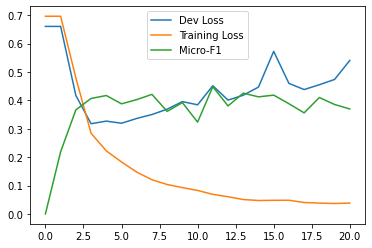

Epoch 21 Test: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

Finished Training


In [83]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_cnn.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    training_loss_epoch = []
    
    model_cnn.train()
    
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        img = img.to(device)
        
        y_true = y_true.to(device).float()

        y_pred = model_cnn(img)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model_cnn.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
        
            img = img.to(device)

            y_true = y_true.to(device).float()

            # computamos la predicción
            y_pred = model_cnn(img)
            
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())
            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model_cnn, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


In [84]:
model_cnn = torch.load('best-model_cnn.pt')
model_cnn.eval()
model_cnn = model_cnn.to('cpu')

In [85]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [86]:
a = model_cnn.forward(ww)

In [87]:
r = torch.round(torch.sigmoid(a))

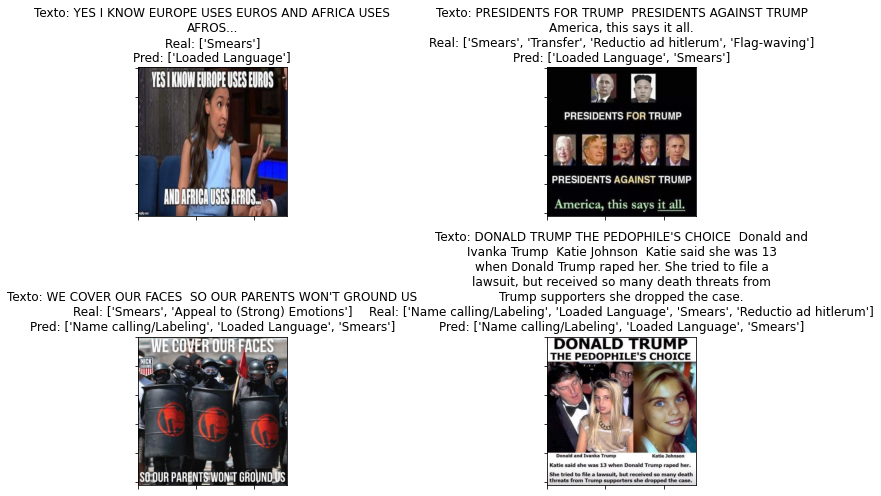

In [88]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())

En mi experimentación, el mejor desempeño se logró al reentrenar solo la última capa convolucional de la red (y obviamente el clasificador final que se agregó).

Parece que la red tiene una capacidad medianamente buena para predecir. No obstante, es posible que la mayor parte de esta capacidad provenga de como se ven los datos. Las etiquetas reales suelen ser muy dispersas, y 'smear' es sumamente común. Habrá que experimentar más para ver si las imágenes pueden ayudar a las predicciones.

## Modelo Multimodal

Esta es la primera propuesta de modelo multimodal que realicé. En esta, se tienen la red neuronal así como la red recurrente. Ambas están pre-entrenadas, y se agregarán con un clasificador al final.

En esta ocasión, se volverán a re-entrenar toda la red recurrente así como la última capa convolucional de la red convolucional.

In [162]:
class PropagandaNet(nn.Module):
    
    def __init__(self, pretrained_cnn, pretrained_rnn):
        super(PropagandaNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = pretrained_cnn
        self.rnn = pretrained_rnn
        
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.reg = nn.Identity()

        self.rnn.fc1 = nn.Identity()

        in_features_cnn = 1024
        in_features_rnn = 100
        # armamos la capa de regresión
     
        #congelado de características
        for param in self.cnn.parameters():
            param.requires_grad = False
        for param in self.cnn.cnn.conv5.parameters():
            param.requires_grad = True
        for param in self.rnn.parameters():
            param.requires_grad = True
    
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features_cnn + in_features_rnn),
            nn.Linear(in_features_cnn + in_features_rnn, 22)
        )
    def forward(self, img, inp, inp_len, device):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(img)
        y = self.rnn(inp, inp_len, device)
        z = torch.cat((x,y),1)
        # [N, 1124] => [N, 22]
        z = self.reg(z)
        return z

In [163]:
torch.cuda.empty_cache()

In [164]:
model_cnn = torch.load('best-model_cnn.pt')
model = torch.load('best-model.pt')
model_2 = PropagandaNet(model_cnn, model)

In [165]:
summary(model_2)

Layer (type:depth-idx)                        Param #
├─ConvNet: 1-1                                --
|    └─ShuffleNetV2: 2-1                      --
|    |    └─Sequential: 3-1                   (696)
|    |    └─MaxPool2d: 3-2                    --
|    |    └─Sequential: 3-3                   (6,936)
|    |    └─Sequential: 3-4                   (45,552)
|    |    └─Sequential: 3-5                   (89,952)
|    |    └─Sequential: 3-6                   198,656
|    |    └─Identity: 3-7                     --
|    └─Identity: 2-2                          --
├─GRUTagger: 1-2                              --
|    └─Embedding: 2-3                         723,350
|    └─GRU: 2-4                               76,200
|    └─Identity: 2-5                          --
├─Sequential: 1-3                             --
|    └─BatchNorm1d: 2-6                       2,248
|    └─Linear: 2-7                            24,750
Total params: 1,168,340
Trainable params: 1,025,204
Non-trainable params

In [166]:
# movemos el modelo 
model_2 = model_2.to(device)
next(model_2.parameters()).device

device(type='cuda', index=0)

In [168]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_2.parameters())#lr = 0.0003)#, weight_decay = 1e-5)

In [169]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 10
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 19
Last model save was in epoch 9
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.02943938281820264
[Best iter] dev loss is: 0.4072625797528487
[Best iter] F1 is: 0.45434782608695656
###############################################
[Last iter] training loss was: 0.008880387547664171
[Last iter] dev. loss was: 0.49723359713187587
[Last iter] F1 was: 0.4282407407407408
###############################################


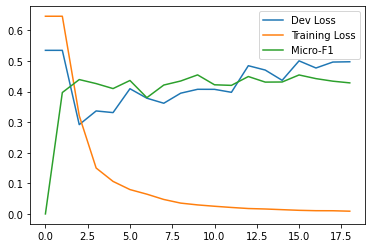

Epoch 19 Train:   0%|          | 0/43 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 19 Test: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

Finished Training


In [170]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_2.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        for param in model_2.rnn.embedding.parameters():
            param.requires_grad = True
    else:
         print("Embeddings are not being trained yet.")
    
    model_2.train()
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        img = img.to(device)
        
        y_true = y_true.to(device).float()
        
        text = text.to(device)

        y_pred = model_2(img, text, text_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model_2.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
        
            img = img.to(device)

            y_true = y_true.to(device).float()

            text = text.to(device)
            # computamos la predicción
            y_pred = model_2(img, text, text_lens, device)
            
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())
            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model_2, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


## 5. Probando

In [171]:
model_2 = torch.load('best-model_2.pt')
model_2.eval()
model_2 = model_2.to('cpu')

### 5.1 Evaluando en dev

In [172]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [173]:
a = model_2.forward(ww, zz_pad, z_lens, 'cpu')

In [174]:
r = torch.round(torch.sigmoid(a))

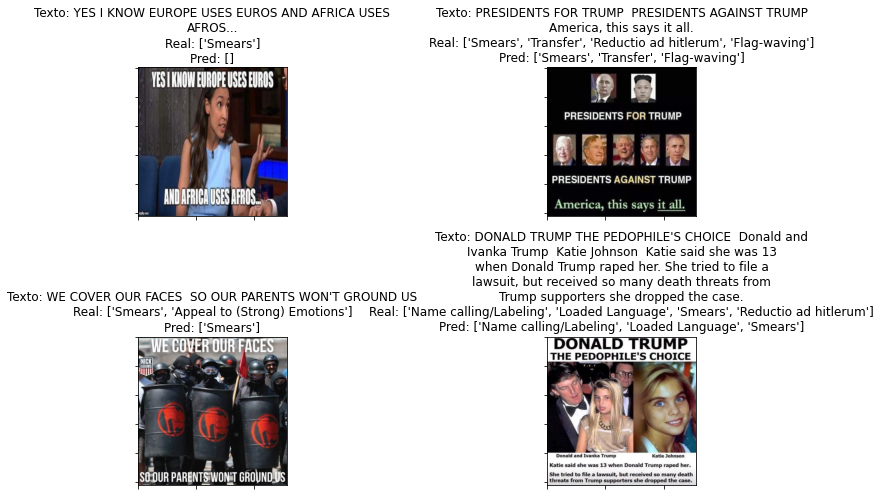

In [175]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())

En este caso, parece ser que el mejor desempeño se obtiene cuando se reentrenan la última capa de la red convolucional, así como la RNN. No obstante, no conozco el desempeño de tener solo una red recurrente sin las imágenes en el problema. Por esto mismo, procederé a realizar el mismo experimento pero excluyendo a las imaǵenes.

### Probando solo la GRU (entrenando desde cero).

In [222]:
model_3 = GRUTagger(2, 0.4, weights_matrix, 50, 50, 22)
for param in model.embedding.parameters():
    param.requires_grad = False

In [223]:
torch.cuda.empty_cache()

In [224]:
# movemos el modelo 
model = model_3.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [225]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())#, lr=0.0001)#, lr=5e-4)#, weight_decay=5e-4)

In [226]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 10
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 57
Last model save was in epoch 47
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.12277217573204706
[Best iter] dev loss is: 0.3523330023655525
[Best iter] F1 is: 0.4816053511705685
###############################################
[Last iter] training loss was: 0.10137787773165592
[Last iter] dev. loss was: 0.37353540039979494
[Last iter] F1 was: 0.4656917885264342
###############################################


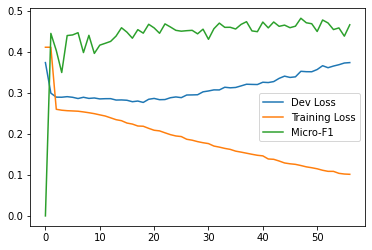

Epoch 57 Train:   0%|          | 0/43 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 57 Test: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]

Finished Training


In [227]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_3.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        model.train()
        for param in model.embedding.parameters():
            param.requires_grad = True
    else:
        print("Embeddings are not being trained yet.")
        model.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        text = text.to(device)
        
        
        y_true = y_true.to(device).float()
        
        y_pred = model(text, text_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
            
            text = text.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(text, text_lens, device)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())
            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


## 5. Probando

In [228]:
model = torch.load('best-model_3.pt')
model.eval()
model = model.to('cpu')

### 5.1 Evaluando en dev

In [229]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [230]:
a = model.forward(zz_pad, z_lens, 'cpu')

In [231]:
r = torch.round(torch.sigmoid(a))

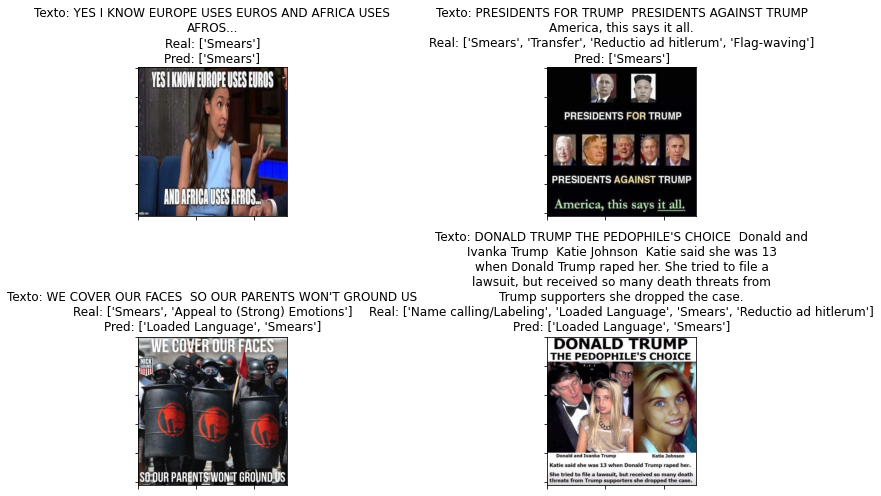

In [232]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())

### Probando solo la GRU (usando transfer learning).

In [233]:
model_3 = GRUTagger(2, 0.4, weights_matrix, 50, 50, 22)
model = torch.load('best-model.pt')
model_3.gru = model.gru
model_3.embedding = model.embedding
for param in model.embedding.parameters():
    param.requires_grad = False

In [234]:
torch.cuda.empty_cache()

In [235]:
# movemos el modelo 
model = model_3.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [236]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())#, lr=0.0001)#, lr=5e-4)#, weight_decay=5e-4)

In [237]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 10
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 17
Last model save was in epoch 7
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.23697453702605048
[Best iter] dev loss is: 0.2771349216882999
[Best iter] F1 is: 0.4801812004530011
###############################################
[Last iter] training loss was: 0.18763502444638763
[Last iter] dev. loss was: 0.2867614672734187
[Last iter] F1 was: 0.4411764705882353
###############################################


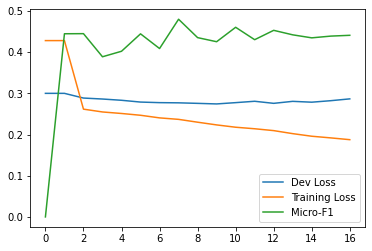

Epoch 17 Train:   0%|          | 0/43 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 17 Test: 100%|██████████| 13/13 [00:02<00:00,  4.72it/s]

Finished Training


In [238]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_3.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        model.train()
        for param in model.embedding.parameters():
            param.requires_grad = True
    else:
        print("Embeddings are not being trained yet.")
        model.train()
        
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        text = text.to(device)
        
        
        y_true = y_true.to(device).float()
        
        y_pred = model(text, text_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
            
            text = text.to(device)
            
            y_true = y_true.to(device).float()
            # computamos la predicción
            y_pred = model(text, text_lens, device)
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())
            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


## 5. Probando

In [239]:
model = torch.load('best-model_3.pt')
model.eval()
model = model.to('cpu')

### 5.1 Evaluando en dev

In [240]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [241]:
a = model.forward(zz_pad, z_lens, 'cpu')

In [242]:
r = torch.round(torch.sigmoid(a))

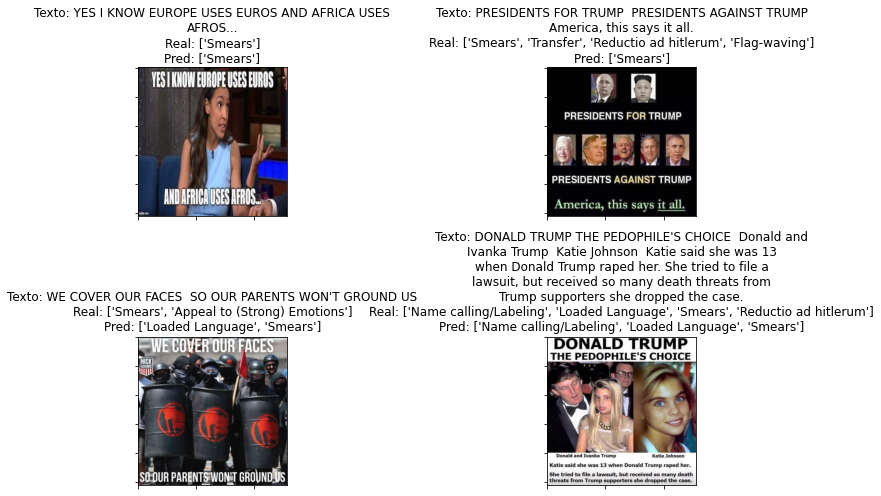

In [243]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())

Parece que el desempeño es mejor sin las imágenes. Esto me lleva a pensar que el vector generado por la red recurrente no se beneficia de conocer la imagen a posterior. Tal vez integrar este conocimiento antes de la interpretación del texto ayudaría.

# Enfoque alterno: Aprender el estado oculto en base a la imagen

En este experimento buscaré aplicar aprendizaje multimodal con otro enfoque. La idea será que se aprenda la inicialización oculta de la red recurrente (que anteriormente eran ceros) por medio de la red convolucional. Mi intuición es que conocer algo de la imagen antes de interpretar el texto podría ayudar a la predicción de las etiquetas.

In [254]:
class PropagandaNet2(nn.Module):
    def __init__(self, stacked_layers, dropout_p, weights_matrix, embedding_dim, hidden_dim, output_size = 22):
        super(PropagandaNet2, self).__init__()
        
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la GRU
        self.stacked_layers = stacked_layers # Cuantas capas en la GRU
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).float(), freeze = False)
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=True)
        self.rnn = nn.GRU(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            batch_first = True,
                            bidirectional = True)
        
        # remplazamos la FC para dejar intactas 
        # las características (diablito)

        self.cnn.fc = nn.Identity()
        
        in_features_cnn = 1024
        in_features_rnn = hidden_dim * 2
        
        self.cnn_adapter = nn.Linear(in_features_cnn, self.stacked_layers * 2 * self.hidden_dim)
        
        # Linear layers
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features_rnn),
            nn.Linear(in_features_rnn, 22)
        )
        
        for param in self.cnn.parameters():
            param.requires_grad = False
        for param in self.cnn.conv5.parameters():
            param.requires_grad = False

    def forward(self, img, inp, inp_len, device):
        #Vector de inicializacion derivado de la imagen
        x = self.cnn(img)
        
        hidden_init = self.cnn_adapter(x)
        hidden_init = hidden_init.reshape(self.stacked_layers * 2, -1, self.hidden_dim)
        
                                    
        #Obtengo embeddings
        emb = self.embedding(inp)
        emb_padded = pack_padded_sequence(emb, inp_len, batch_first=True, enforce_sorted=False)
        
        #Corro la LSTM
        output, _ = self.rnn(emb_padded, hidden_init)#(hidden_init, cell_init))
        #Desempaco LSTM                            
        seq_unpacked, lens_unpacked  = pad_packed_sequence(output, batch_first=True)
        #Obtengo los últimos elementos
        output = seq_unpacked[torch.arange(emb.size()[0]), lens_unpacked-1]
        #Paso por clasificador

        # [N, 1124] => [N, 22]
        z = self.classifier(output)
        return z

In [255]:
model_3 = PropagandaNet2(2, 0.4, weights_matrix, 50, 50, 22)

In [256]:
summary(model_3)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         723,350
├─ShuffleNetV2: 1-2                      --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (648)
|    |    └─BatchNorm2d: 3-2             (48)
|    |    └─ReLU: 3-3                    --
|    └─MaxPool2d: 2-2                    --
|    └─Sequential: 2-3                   --
|    |    └─InvertedResidual: 3-4        (2,400)
|    |    └─InvertedResidual: 3-5        (1,512)
|    |    └─InvertedResidual: 3-6        (1,512)
|    |    └─InvertedResidual: 3-7        (1,512)
|    └─Sequential: 2-4                   --
|    |    └─InvertedResidual: 3-8        (8,256)
|    |    └─InvertedResidual: 3-9        (5,328)
|    |    └─InvertedResidual: 3-10       (5,328)
|    |    └─InvertedResidual: 3-11       (5,328)
|    |    └─InvertedResidual: 3-12       (5,328)
|    |    └─InvertedResidual: 3-13       (5,328)
|    |    └─InvertedResidual: 3-14       (5,328)
|    |

In [257]:
for param in model_3.embedding.parameters():
    param.requires_grad = False

In [258]:
# movemos el modelo 
model_3 = model_3.to(device)
next(model_3.parameters()).device

device(type='cuda', index=0)

In [259]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_3.parameters(), lr = 1e-4)#, lr = 8e-4)

In [260]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 10
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 72
Last model save was in epoch 62
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.21858299852803695
[Best iter] dev loss is: 0.27568247799689954
[Best iter] F1 is: 0.45843230403800483
###############################################
[Last iter] training loss was: 0.20856222787568734
[Last iter] dev. loss was: 0.2740351099234361
[Last iter] F1 was: 0.4482338611449452
###############################################


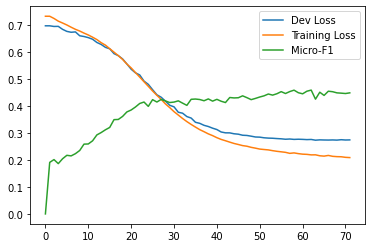

Epoch 72 Train:   0%|          | 0/43 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 72 Test: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

Finished Training


In [261]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_3.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        for param in model_3.embedding.parameters():
            param.requires_grad = True
    else:
        print("Embeddings are not being trained yet.")
    
    model_3.train()
    
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        img = img.to(device)
        
        y_true = y_true.to(device).float()
        
        text = text.to(device)

        y_pred = model_3(img, text, text_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model_3.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
        
            img = img.to(device)

            y_true = y_true.to(device).float()

            text = text.to(device)
            # computamos la predicción
            y_pred = model_3(img, text, text_lens, device)
            
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())
            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
            
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model_3, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


In [262]:
model = torch.load('best-model_3.pt')
model.eval()
model = model.to('cpu')

### 5.1 Evaluando en dev

In [263]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [264]:
a = model.forward(ww, zz_pad, z_lens, 'cpu')

In [265]:
r = torch.round(torch.sigmoid(a))

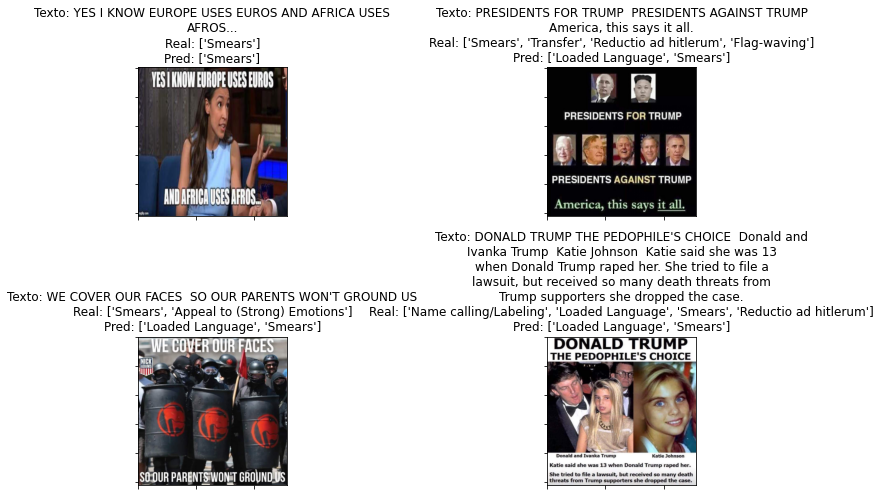

In [266]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())

# Enfoque alterno: Agregar una representación de la imagen a embeddings

In [197]:
class PropagandaNet2(nn.Module):
    def __init__(self, stacked_layers, dropout_p, weights_matrix, embedding_dim, hidden_dim, output_size = 22):
        super(PropagandaNet2, self).__init__()
        
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la GRU
        self.stacked_layers = stacked_layers # Cuantas capas en la GRU
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).float(), freeze = False)
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=True)
        self.rnn = nn.GRU(embedding_dim * 2,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            batch_first = True,
                            bidirectional = True)

        self.cnn.fc = nn.Identity()

        
        in_features_cnn = 1024
        in_features_rnn = hidden_dim * 2
        
        self.cnn_adapter = nn.Linear(in_features_cnn, embedding_dim)#Adapto la imagen a un vector
        
        
        # Linear layers
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features_rnn),
            nn.Linear(in_features_rnn, 22)
        )
        
        for param in self.cnn.parameters():
            param.requires_grad = False
        for param in self.cnn.conv5.parameters():
            param.requires_grad = True

    def forward(self, img, inp, inp_len, device):
        #Vector de inicializacion derivado de la imagen

        x = self.cnn(img)
        
        max_length = inp.size()[1]
        
        img_vec = self.cnn_adapter(x).unsqueeze(1).repeat(1, max_length, 1)
        
                                    
        #Obtengo embeddings
        emb = self.embedding(inp)
        #print(emb.size())
        
        emb = torch.cat((emb, img_vec), 2)
        
        emb_padded = pack_padded_sequence(emb, inp_len, batch_first=True, enforce_sorted=False)
        
        #Corro la LSTM
        output, _ = self.rnn(emb_padded)#, hidden_init)#(hidden_init, cell_init))
        #Desempaco LSTM                            
        seq_unpacked, lens_unpacked  = pad_packed_sequence(output, batch_first=True)
        #Obtengo los últimos elementos
        output = seq_unpacked[torch.arange(emb.size()[0]), lens_unpacked-1]
        #Paso por clasificador
        z = self.classifier(output)
        return z

In [198]:
model_3 = PropagandaNet2(2, 0.4, weights_matrix, 50, 100, 22)

In [199]:
summary(model_3)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         723,350
├─ShuffleNetV2: 1-2                      --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (648)
|    |    └─BatchNorm2d: 3-2             (48)
|    |    └─ReLU: 3-3                    --
|    └─MaxPool2d: 2-2                    --
|    └─Sequential: 2-3                   --
|    |    └─InvertedResidual: 3-4        (2,400)
|    |    └─InvertedResidual: 3-5        (1,512)
|    |    └─InvertedResidual: 3-6        (1,512)
|    |    └─InvertedResidual: 3-7        (1,512)
|    └─Sequential: 2-4                   --
|    |    └─InvertedResidual: 3-8        (8,256)
|    |    └─InvertedResidual: 3-9        (5,328)
|    |    └─InvertedResidual: 3-10       (5,328)
|    |    └─InvertedResidual: 3-11       (5,328)
|    |    └─InvertedResidual: 3-12       (5,328)
|    |    └─InvertedResidual: 3-13       (5,328)
|    |    └─InvertedResidual: 3-14       (5,328)
|    |

In [200]:
for param in model_3.embedding.parameters():
    param.requires_grad = False

In [201]:
# movemos el modelo 
model_3 = model_3.to(device)
next(model_3.parameters()).device

device(type='cuda', index=0)

In [202]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_3.parameters())#, lr = 8e-4)

In [203]:
loss_per_epoch = [0]
training_loss = [0]
f1_loss = [0]
stop_after_best = 20
start_training_embeddings_at = 1000
best_l = None
best_tl = None
best_f1 = None
worst_l = 0
worst_tl = 0
worst_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 45
Last model save was in epoch 25
Stopping training in: 1 epochs.
###############################################
[Best iter] training loss is: 0.025398585338925205
[Best iter] dev loss is: 0.5055968394646277
[Best iter] F1 is: 0.49337410805300713
###############################################
[Last iter] training loss was: 0.011207230654436835
[Last iter] dev. loss was: 0.614818600507883
[Last iter] F1 was: 0.47009443861490036
###############################################


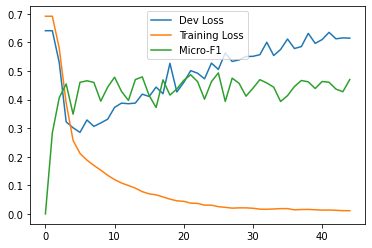

Epoch 45 Train:   0%|          | 0/43 [00:00<?, ?it/s]

Embeddings are not being trained yet.


Epoch 45 Test: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

Finished Training


In [204]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

#Nombre del archivo de backup
savefile = 'best-model_3.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 10 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training loss is: " + str(best_tl))
    print("[Best iter] dev loss is: " + str(best_l))
    print("[Best iter] F1 is: " + str(best_f1))
    print("###############################################")
    print("[Last iter] training loss was: " + str(training_loss[-1]))
    print("[Last iter] dev. loss was: " + str(loss_per_epoch[-1]))
    print("[Last iter] F1 was: " + str(f1_loss[-1]))
    print("###############################################")
    
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_loss)
    plt.legend(["Dev Loss", "Training Loss", "Micro-F1"])
    plt.show()
    
    true_dev = []
    pred_dev = []
    
    if epochs >= start_training_embeddings_at:
        print("Embeddings are being trained.")
        for param in model_3.embedding.parameters():
            param.requires_grad = True
    else:
        print("Embeddings are not being trained yet.")
    
    model_3.train()
    
    training_loss_epoch = []
        
    for i, data in tqdm(enumerate(trn_dl, 0), desc=f'Epoch {epochs:2d} Train', total=len(trn_dl)):

        img, y_true, _, text, text_lens = data
        
        img = img.to(device)
        
        y_true = y_true.to(device).float()
        
        text = text.to(device)

        y_pred = model_3(img, text, text_lens, device)
        
        loss = criterion(y_pred, y_true)
        
        training_loss_epoch.append(loss.item())
        
        # vaciamos los gradientes
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print("Batch "+ str(i+1) + " done.")
    tl = np.mean(training_loss_epoch) #Asumo lotes del mismo tamaño
    
    val_loss_epoch = []
    
    #evaluar el modelo
    model_3.eval()
    
    with torch.no_grad():
        for data in tqdm(dev_dl, desc=f'Epoch {epochs:2d} Test', total=len(dev_dl)):
            
            img, y_true, _, text, text_lens = data
        
            img = img.to(device)

            y_true = y_true.to(device).float()
            
            text = text.to(device)
            # computamos la predicción
            y_pred = model_3(img, text, text_lens, device)
            
            # computamos la pérdida
            val_loss_epoch.append(criterion(y_pred, y_true).item())

            true_dev.append(y_true.to('cpu'))
            pred_dev.append(y_pred.to('cpu'))
            
    l = np.mean(val_loss_epoch)        
        
    t_d = torch.cat(true_dev, 0).numpy()
    p_d = torch.cat(pred_dev, 0)
    
    p_d = torch.round(torch.sigmoid(p_d)).detach().numpy()
    
    
    f1 = f1_score(t_d, p_d, average='micro')  
        
    epochs_without_change += 1
    if best_f1 is None or best_f1 <= f1:
        torch.save(model_3, savefile)
        best_l = l
        best_tl = tl
        best_f1 = f1
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    
    #Para graficar con una escala coherente.
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl

    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
        
    if(f1 < worst_f1):
        worst_f1 = f1
        f1_loss[0] = worst_f1
        
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_loss.append(f1)
    #Rastreo la época actual
    epochs += 1
    sys.stdout.flush()
print('Finished Training')


In [205]:
model = torch.load('best-model_3.pt')
model.eval()
model = model.to('cpu')

### 5.1 Evaluando en dev

In [206]:
ww, xx, yy, zz_pad, z_lens = next(iter(dev_dl))

In [207]:
a = model.forward(ww, zz_pad, z_lens, 'cpu')

In [208]:
r = torch.round(torch.sigmoid(a))

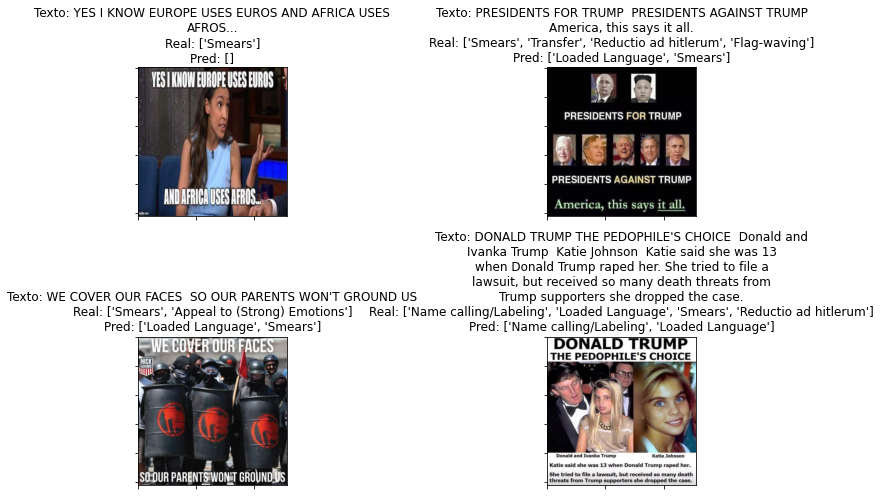

In [209]:
display_batch(ROWS, COLS, ww,yy, xx, idx_class, y_pred=r.detach())